Populating the interactive namespace from numpy and matplotlib
Rank is: 3


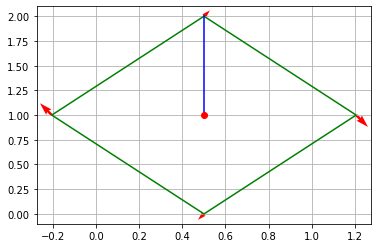

In [108]:
%pylab inline
import matplotlib.pyplot as plt

def plotsim(x_log):
    x_log = array(x_log)

    plt.figure(figsize=(5,5))
    plot(x_log[:,0], x_log[:,1])
    xlabel('x')
    ylabel('z')
    plt.tight_layout()
    fig = plt.figure(figsize=(10,5))
    subplot(3,3,1)
    plot(time[1:],x_log[:-1,0])
    xlabel('t')
    ylabel('x')  
    subplot(3,3,2)
    plot(time[1:],x_log[:-1,1])
    xlabel('t')
    ylabel('z')
    subplot(3,3,3)
    plot(time[1:],x_log[:-1,2])
    xlabel('t')
    ylabel('phi')    
    plt.show()

RotY = lambda θ: [[cos(θ), 0, sin(θ)], 
         [0, 1, 0],
         [-sin(θ), 0, cos(θ)]]

def vehicle_se2(x, z, θ, D, u=[0,0,0,0], ax=plt.axes()):  
    
    # Design
    pxs = list(D[:,0])
    pzs = list(D[:,1])    
    αs  = copy(D[:,2])
    
    # Rotate
    R = RotY(θ)
    points = D[:,:2]
    points = array([np.dot(R, [px,0,pz]) for px,pz in points])
    pxs = points[:,0]
    pzs = points[:,2]
    αs += θ
    
    # Translate
    pxs += x
    pzs += z
    
    # propellers
    e1 = [1,0,0]    
    prop_x = array([np.dot(RotY(α), e1)[0] for α in αs])
    prop_z = array([np.dot(RotY(α), e1)[2] for α in αs])
    
    # Plot propellers
    #ax.quiver(pxs, pzs, prop_x, prop_z, scale=20)
    
    # control input    
    ax.quiver(pxs, pzs, u*prop_x, u*prop_z, scale=40, color='r')
    
    # Plot Frame           
    ax.plot(list(pxs) + [pxs[0]], list(pzs) + [pzs[0]],'g')
    ax.plot([x, pxs[0]], [z, pzs[0]],'b')    
    ax.plot(x,z, 'ro')  # Center of mass

#Design
D = array([[0, 1, -pi/4],
          [-cos(pi/4), 0, -3*pi/4],
          [0, -1, 3*pi/4],
          [cos(pi/4), 0, pi/4]])

x, z, θ = 0.5, 1, 0
u = 1,2,1,2
vehicle_se2(x, z, θ, D, u)
grid()

αs = copy(D[:,2])
co = cos(αs)
si = sin(αs)

#points
pxs = list(D[:,0])
pzs = list(D[:,1])

A = array([co, si, [pzs[0]*co[0]-pxs[0]*si[0], pzs[1]*co[1]-pxs[1]*si[1], pzs[2]*co[2]-pxs[2]*si[2], pzs[3]*co[3]-pxs[3]*si[3]]])

#print(A)
print('Rank is:', np.linalg.matrix_rank(A))

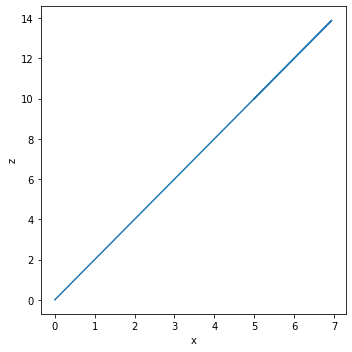

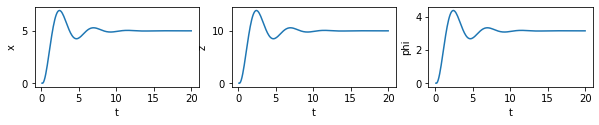

In [109]:
def simulate(Δt,x,dx):
    x = x + Δt*dx
    return x

tf = 20
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval
g = 9.8
gv = [0, 0, -g]
Iy = 1
m = 1
kp = array([2,2,2])
kd = array([1,1,1])

#Initial condition
x = np.array([0, 0, 0, 0, 0, 0])

#Desired configuration
x_d = np.array([5, 10, pi, 0, 0, 0])

dx = np.zeros(6)

x_log = [copy(x)]
u_log = [[0,0,0,0]]

for t in time[1:]:
    px, pz, θ, vx, vz, vθ = x
    px_d, pz_d, θ_d, vx_d, vz_d, vθ_d = x_d
    
    e_pos = array(x_d[0:3] - x[0:3])
    e_vel = array(x_d[3:6] - x[3:6])
    a = kp*e_pos.T + kd*e_vel.T
    
    B1 = [[cos(θ)/m, sin(θ)/m, 0],
      [-sin(θ)/m, cos(θ)/m, 0],
      [0, 0, 1/Iy]]
    
    B = np.dot(B1, A)
    iB = np.linalg.pinv(B)
    u = np.dot(iB, (a + gv))
    
    a = np.dot(B,u) - gv
    
    dx[:3] = x[3:]
    dx[3:] = a
    x = simulate(Δt, x, dx)
    x_log.append(copy(x))
    u_log.append(u)

plotsim(x_log)

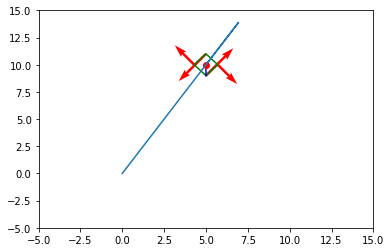

In [106]:
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

fig, ax = plt.subplots()
x_log = array(x_log)
u_log = array(u_log)

def animate(t):
    ax.clear()
    ax.set_xlim(-5,15)
    ax.set_ylim(-5,15)
    px, pz, θ, vx, vz, vθ = x_log[t]
    u = u_log[t]
    vehicle_se2(px, pz, θ, D, u, ax)
    plot(x_log[:,0], x_log[:,1])

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=50)
display(HTML(anim.to_jshtml()))